# Extended Kalman Filter (EKF)

Let us summarize first Kalman filtering using notation of [Welch and Bishop (2006)](http://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf).

Parts of linear system model:

* state transition matrix: $\mathbf{A}$
* inital state and its covariance matrix: $\mathbf{x}_0$, $\mathbf{P}_0$
* control matrix: $\mathbf{B}$
* system noise covariance matrix: $\mathbf{Q}$
* measurement matrix: $\mathbf{H}$
* measurement noise covariance matrix: $\mathbf{R}$

Update estimate of system's state vector $\hat{\mathbf{x}}_k$ from equations of the filter: 

1. previous state and its covariance: $\hat{\mathbf{x}}_{k-1}$, $\mathbf{P}_{k-1}$

2. prediction of state for the next epoch

    1. prediction of system state:  $ \hat{\mathbf{x}}_{k}^{-} = \mathbf{A}\hat{\mathbf{x}}_{k-1} + \mathbf{B}\mathbf{u}_{k-1} $
    
    2. prediction of system state covariance:  $ \mathbf{P}_{k}^{-} = \mathbf{A}\mathbf{P}_{k-1}\mathbf{A}^T + \mathbf{Q} $

3. measurement update of system state

    1. Kalman gain matrix: $ \mathbf{K}_k = \mathbf{P}_k^-{} \mathbf{H}_k^T (\mathbf{H} \mathbf{P}_k^-{} \mathbf{H}^T + \mathbf{R})^{-1} $
    
    2. system state update from measurements $\mathbf{z}_k$: $\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_k^-{} + \mathbf{K}_k (\mathbf{z}_k - \mathbf{H}(\hat{\mathbf{x}}_k^-{})) $
    
    3. covariance matrix of updated system state: $\mathbf{P}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \mathbf{P}_k^-{}$
    
As it was mentioned the most difficult part is to set up a correct model of the system under study. In the following we try to create the system model for a simple navigation problem.

## Odometry from wheel-mounted two-axis accelerometry

We have the following problem: determine distance traveled by a wheel from the data of a wheel-mounted two-axis accelerometer sensor. Let us assume that the wheel is rolling without slipping on a horizontal surface.

Rolling *without slipping* consists of linear motion plus rolling. The instantaneous point of contact has zero velocity, see the following figure:

<img src="./img/roll1.png" width="600"/>

In the following figure the two-axis accelerometer S is shown attached to the wheel of radius $r_w$ at a distance $r_s$ from its centre O. The first axis of the sensor is perpendicular to the radius pointing along in the positive (clockwise) direction of rotation, while its second axis points to the centre radially inwards. 

<img src="./img/roll2.png" width="300" />

Components of the vector of gravity $\mathbf{g}$ along the axes of the sensor are:

$$a_1=-g\sin(\theta)$$
$$a_2=-g\cos(\theta)$$.

If the centre O of the wheel has linear acceleration $\ddot{p}$, proof mass of the sensor S experiences an acceleration in the opposite direction according to the figure

<img src="./img/gordul3.png" width="300" />

the components of which are:

$$a_1=\ddot{p}\cos(\theta)$$
$$a_2=-\ddot{p}\sin(\theta)$$.



Finally, accelerated rotation of the wheel causes centripetal and centrifugal accelerations along $a_1$ and $a_2$, respectively.

<img src="./img/roll4.png" width="300"/>

Due to the no-slip condition of the wheel rotation angle $\theta$, angular velocity $\dot\theta$ and angular acceleration $\ddot\theta$ are related to distance $p$, velocity $\dot{p}$ and linear acceleration $\ddot{p}$:

$$\theta=\frac{p}{r_w}$$
$$\dot\theta=\frac{\dot{p}}{r_w}$$
$$\ddot\theta=\frac{\ddot{p}}{r_w}$$

Therefore, accelerations along sensor axes are

$$a_1=-r_s \ddot\theta = -\frac{r_s}{r_w}\ddot{p}$$
$$a_2=-r_s \dot\theta^2 = -\frac{r_s}{r_w^2}\dot{p}^2$$

Components of the *full* sensor acceleration thus may be written as:

$$a_1=-g\sin(\frac{p}{r_w})+\ddot{p}\cos(\frac{p}{r_w})-\frac{r_s}{r_w}\ddot{p}$$
$$a_2=-g\cos(\frac{p}{r_w})-\ddot{p}\sin(\frac{p}{r_w})-\frac{r_s}{r_w^2}\dot{p}^2$$


### State and measurement function

System *state vector* $\mathbf{x}$ for Kalman filtering is composed of position, velocity and acceleration of the wheel

$$\mathbf{x} = \begin{bmatrix}
p\\ 
\dot p\\ 
\ddot p
\end{bmatrix} .$$

Measurement function $h(\mathbf{x},\mathbf{v})$ is a function of measured accelerations 

$$ h(\mathbf{x},\mathbf{v}) = \begin{bmatrix}
-g\sin\left(\frac{p}{r_w}\right)+\ddot{p}\cos\left(\frac{p}{r_w}\right)-\frac{r_s}{r_w}\ddot{p} + v_1\\ 
-g\cos\left(\frac{p}{r_w}\right)-\ddot{p}\sin\left(\frac{p}{r_w}\right)-\frac{r_s}{r_w^2}\dot{p}^2 + v_2
\end{bmatrix} $$

where $\mathbf{v}=(v_1,v_2)$ denotes measurement noise, which is a Gaussian distributed random variable with zero mean.

The above function is <b><span style="color:red;"> nonlinear </span></b>, hence the basic Kalman filter cannot be used for this problem. Instead the **Extended Kalman Filter** will be used. This involves linearization of nonlinear equations at measurements and system state estimation.

First we define in Python the measurement function for later use:

In [1]:
def h(x,rs,rw):
    ## measurement function
    ## x  = state vector (p,pdot,pdotdot)
    ## rs = distance of sensor from wheel axis
    ## rw = wheel radius
    g = 9.81
    h1 = -g*np.sin(x[0]/rw) + x[2]*np.cos(x[0]/rw) - x[2]*rs/rw
    h2 = -g*np.cos(x[0]/rw) - x[2]*np.sin(x[0]/rw) - (x[1])**2*rs/(rw**2)
    return np.array([h1,h2]).flatten()

State transition matrix $A$ is already linear:

$$ A = \begin{bmatrix}
1 & \Delta t & \frac{1}{2}\Delta t^2 \\ 
0 & 1 & \Delta t\\ 
0 & 0 & 1
\end{bmatrix}$$

It is thus easy to define the state propagation function in Python:

In [2]:
def f(x,dt):
    """ state propagation function
     x  = state vector (p,pdot,pdotdot)
     dt = time difference
    """
    f1 = x[0] + x[1]*dt + 0.5*x[2]*dt**2
    f2 = x[1] + x[2]*dt
    f3 = x[2]
    return np.array([f1,f2,f3]).flatten()

## Equations of the Extended Kalman Filter (EKF)


In cases where either the measurement or state update equation or both are nonlinear, we need formulas of extended Kalman filtering.

State of the system changes according to the nonlinear function $f$:

$$ x_k = f(\mathbf{x}_{k-1}, \mathbf{u}_{k-1}, \mathbf{w}_{k-1})$$

where $\mathbf{w}$ denotes system noise. Moreover, measurements $\mathbf{z}$ are connected with system state $x$ through the following nonlinear function $f$:

$$z_k = h(\mathbf{x}_k, \mathbf{v}_k),$$

where $\mathbf{v}$ denotes measurement noise. Generally, of course, these noises are unknown, hence system state and vector of measurements are calculated without these noises:

$$ \tilde{\mathbf{x}_k} = f(\hat{\mathbf{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0})$$
$$ \tilde{\mathbf{z}_k} = h(\tilde{\mathbf{x}}_k, \mathbf{0})$$

where $\hat{\mathbf{x}}_{k-1}$ denotes estimate of previous system state vector. It is important to make a remark: a basic flaw of the extended Kalman filter is that since transformed Gaussian PDFs of random variables become non-Gaussian, the estimate cannot be optimal.

Linearization of the equations yields

$$ \mathbf{x}_k \approx \tilde{\mathbf{x}}_k + \mathbf{A}(\mathbf{x}_{k-1} - \hat{\mathbf{x}}_{k-1}) + \mathbf{W}\mathbf{w}_{k-1}$$

$$ \mathbf{z}_k \approx \tilde{\mathbf{z}}_k + \mathbf{H}(\mathbf{x}_k - \tilde{\mathbf{x}}_{k}) + \mathbf{V}\mathbf{v}_{k},$$

where

* $\mathbf{x}_k$ and $\mathbf{z}_k$ are current state and measurement vectors,
* $\tilde{\mathbf{x}}_k$ and $\tilde{\mathbf{z}}_k$ vectors of state and measurement estimates,
* $\hat{\mathbf{x}}_{k}$ final state estimate at epoch $k$,
* a $\mathbf{w}_{k}$ and $\mathbf{v}_{k}$ are process and measurement noise,
* $\mathbf{A}$ denotes Jacobian of the function $f$ with respect to $\mathbf{x}$,
* $\mathbf{W}$ denotes Jacobian of the function $f$ with respect to $\mathbf{w}$,
* $\mathbf{H}$ denotes Jacobian of the function $h$ with respect to $\mathbf{x}$,
* $\mathbf{v}$ denotes Jacobian of the function $h$ with respect to $\mathbf{v}$.

EKF filter equations provide estimate of system state $\hat{\mathbf{x}}_k$: 

1. estimation of previous system state and covariance: $\hat{\mathbf{x}}_{k-1}$, $\mathbf{P}_{k-1}$

2. prediction to the next epoch

    1. prediction of system state:  $ \hat{\mathbf{x}}_k^{-}=f(\hat{\mathbf{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0}) $
    
    2. prediction of system state covariance:  $ \mathbf{P}_{k}^{-} = \mathbf{A}_k\mathbf{P}_{k-1}\mathbf{A}_k^T + \mathbf{W}_k\mathbf{Q}_{k-1}\mathbf{W}_k^T $

3. system state prediction update from measurements

    1. calculate Kalman gain: $ \mathbf{K}_k = \mathbf{P}_k^-{} \mathbf{H}_k^T (\mathbf{H} \mathbf{P}_k^-{} \mathbf{H}^T + \mathbf{V}_k\mathbf{R}_{k}\mathbf{v}_k^T)^{-1} $
    
    2. system state update from measurements $\mathbf{z}_k$: $\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_k^-{} + \mathbf{K}_k (\mathbf{z}_k - h(\hat{\mathbf{x}}_k^{-}, \mathbf{0})) $
    
    3. calculate covariance of updated system state: $\mathbf{P}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \mathbf{P}_k^-{}$
    

The extended filter in our problem requires writing the **Jacobian** of the nonlinear measurement equation. Jacobian $H$ of measurement function $h(\mathbf{x},\mathbf{v})$ is composed of partial derivatives of the state vector $\mathbf{x}$ according to components ($p$, $\dot{p}$, $\ddot{p}$):

$$ H = \begin{bmatrix}
-\frac{g}{r_w}\cos\left(\frac{p}{r_w}\right)-\frac{\ddot{p}}{r_w}\sin\left(\frac{p}{r_w}\right) & 0 & \cos\left(\frac{p}{r_w}\right)-\frac{r_s}{r_w}\\ 
\frac{g}{r_w}\sin\left(\frac{p}{r_w}\right)-\frac{\ddot{p}}{r_w}\cos\left(\frac{p}{r_w}\right) & -2\frac{r_s}{r_w^2}\dot{p} & -\sin\left(\frac{p}{r_w}\right)
\end{bmatrix} .$$

For the stochastic model we define state noise variance as $q=0.07 m/s^2$, measurement noise variances as $r_1=r_2=5 m/s^2$.

The following Python function is used for calculating the matrix $H$:

In [3]:
def H(x,rs,rw):
    ## Jacobian of the measurement function
    ## x  = state vector (p,pdot,pdotdot)
    ## distance of sensor from wheel axis
    ## rw = wheel radius
    g = 9.81
    H = np.zeros((2,3))
    H[0,0] = -g/rw*np.cos(x[0]/rw) - x[2]/rw*np.sin(x[0]/rw)
    H[0,1] = 0.0
    H[0,2] = np.cos(x[0]/rw)- rs/rw
    H[1,0] = g/rw*np.sin(x[0]/rw) - x[2]/rw*np.cos(x[0]/rw)
    H[1,1] = -2*x[1]*rs/(rw**2)
    H[1,2] = -np.sin(x[0]/rw)
    return H

### Acceleration sensor test data

Paper by [Gersdorf B., Frese U. (2013)](https://pdfs.semanticscholar.org/ab65/2f5c812b580f1c6b154161317b2bb9434655.pdf) contains accelerometer [test data](./dat/a.txt) suitable for extended Kalman filtering. Numerical values are extracted from the figure in the PDF file. Opening PDF in `LibreOffice Draw` the figure in vector format can be saved to `.odg` compressed XML. Using `Notepad++` macros an `Excel` file can be created and used for transforming acceleration data to proper units (m/s<sup>2</sup>). Finally, the `Excel` data file can be exported to ASCII. 

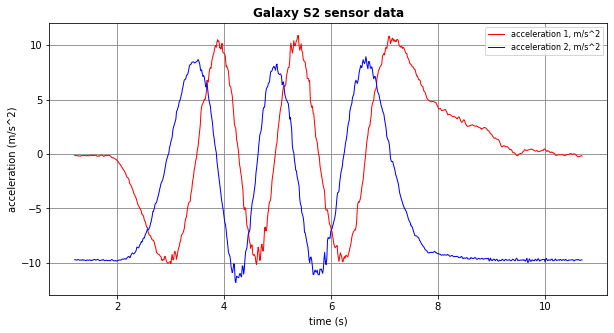

In [4]:
# -*- coding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("./dat/a.txt")
t = data[:,0]
a1= data[:,1]
a2= data[:,2]

# Plot acceleration data
plt.figure(figsize=(10,5))
plt.plot(t,a1, 'r-', label='acceleration 1, m/s^2', lw=1)
plt.plot(t,a2, 'b-', label='acceleration 2, m/s^2', lw=1)
#plt.xlim(30,52)
plt.grid(color='grey')
plt.title('Galaxy S2 sensor data', fontweight='bold')
plt.xlabel('time (s)')
plt.ylabel('acceleration (m/s^2)')
plt.legend(loc='upper right', shadow=False, prop={'size':8}) 
plt.show()

As we have already seen in the first step of extended Kalman filtering the system state is predicted, then it is updated with a new measurement $\mathbf{z}_k$.

prediction:

$$ \hat{\mathbf{x}}_k^-{} = f(\mathbf{x}_k)$$
$$ \mathbf{P}_k^-{} = \mathbf{A} \mathbf{P}_k \mathbf{A}^T + \mathbf{Q} $$

update:

$$ \mathbf{K}_k = \mathbf{P}_k^-{} \mathbf{H}_k^T (\mathbf{H} \mathbf{P}_k^-{} \mathbf{H}^T + \mathbf{R})^{-1} $$
$$ \hat{\mathbf{x}}_k = \hat{\mathbf{x}}_k^-{} + \mathbf{K}_k (\mathbf{z}_k - h(\hat{\mathbf{x}}_k^-{})) $$
$$ \mathbf{P}_k = \mathbf{P}_k^-{} - \mathbf{K}_k \mathbf{H} \mathbf{P}_k^-{} $$

Python function of one step:

In [5]:
def EKFstep(xk,Pk,A,H,Q,R,zk,dt,rs,rw):
    """one step of the extended Kalman filter
    """
    # system state transition (prediction)
    xkm = f(xk,dt)
    Pkm = np.dot(np.dot(A,Pk),A.T) + Q
    # measurement update
    Kk = np.dot(Pkm,np.dot(H.T,np.linalg.pinv(np.dot(np.dot(H,Pkm),H.T) + R)))
    xk1 = xkm + np.dot(Kk,(zk - h(xkm,rs,rw)))
    Pk1 = Pkm - np.dot(np.dot(Kk,H),Pkm)

    return xk1,Pk1

The filtering is implemented in the function **EKFWheel**(t,a1,a2,q,r). Arguments of this function are:
*  t: vector of measurement epochs
* a1, a2: acceleration sensor data at epochs defined by t
*  q: process noise
*  r: measurement noise

The function returns in matrix xe the estimated system state and angular position in the interval $-\pi \le \theta \le \pi$.

Python implementation:

In [6]:
def EKFwheel(t,a1,a2,q=0.07,r=5):
    """
    Odometry using two-axis accelerometer sensor by extended Kalman filtering
     t - vector of measurement epochs
     a1, a2 - measured centrifugal and centripetal accelerations (m/s**2)
     q - process noise variance (m/s**2)
     r - measurement noise variance (m/s**2)
    """
    # sensor offset from wheel axis and wheel radius (Samsung Galaxy S2, bycicle mounted)
    rs = 0.095  # meters
    rw = 0.35   # meters
    nt = t.shape[0]

    # state vector: t, p,vel,acc,theta
    xe = np.zeros((nt,5))
    xe[:,0]=t
    # start
    Q = q**2*np.eye(3)
    R = r**2*np.eye(2)
    xk = np.zeros((3))
    Pk = q**2*np.diag([0, 0, 1])
    Ak = np.zeros((3,3))

    for i in range(1,nt):
        dt = t[i]-t[i-1]
        Hk = H(xk,rs,rw)
        A = np.eye(3)+ np.array([[0,dt,0.5*dt**2], [0,0,dt], [0,0,0]])
        zk = np.array([a1[i],a2[i]])
        # EKF step
        xk1,Pk1 = EKFstep(xk,Pk,A,Hk,Q,R,zk,dt,rs,rw)
        xe[i,1:4] = xk1
        xk = xk1  # state update
        Pk = Pk1  # state covariance updated
        om = xk1[0]/rw  # angular position of the wheel
        xe[i,4]=np.arctan2(np.sin(om),np.cos(om));  # angle: (-pi, pi)

    return xe

Make filtering:

In [7]:
xe = EKFwheel(t,a1,a2,0.17,5.0)

Finally we plot results of the extended Kalman filtering:

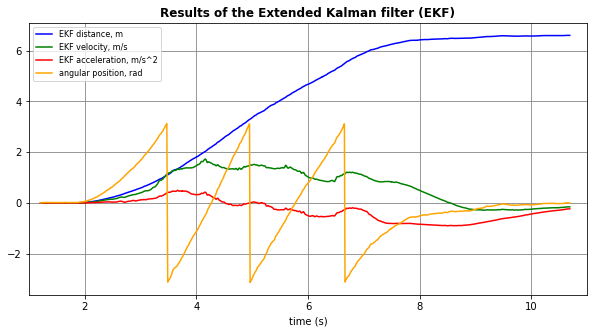

In [8]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.plot(xe[:,0],xe[:,1], 'b-', label='EKF distance, m')
plt.plot(xe[:,0],xe[:,2], 'g-', label='EKF velocity, m/s')
plt.plot(xe[:,0],xe[:,3], 'r-', label='EKF acceleration, m/s^2')
plt.plot(xe[:,0],xe[:,4], color='orange', label='angular position, rad')
plt.xlim(1,11)
plt.grid(color='grey')
plt.title('Results of the Extended Kalman filter (EKF)', fontweight='bold')
plt.xlabel('time (s)')
plt.legend(loc='upper left', shadow=False, prop={'size':8}) 
plt.show()

Let us compare these results with Fig.5 in the paper by [Gersdorf B., Frese U. (2013)](https://pdfs.semanticscholar.org/ab65/2f5c812b580f1c6b154161317b2bb9434655.pdf).

<img src="img/Gersdorf5.png" width="600" />

These results are quite similar to each other but it should be noted that they also used angular velocity data ($\omega$) provided by a giroscopic sensor besides the accelerometer output. We notice also that velocity and acceleration became negative instead of being positive as they should be. We suspect that this is due to the linearization.

### Accelerometer data provided by Ákos Vinkó

Accelerometer sensor <img src="img/logger.png" style="float:right;" width="250" /> data provided by [Ákos Vinkó](https://epito.bme.hu/vinko-akos) (Department of Highway and Railway Engineering) were also used for odometry. These are the tangential and radial acceleration components measured by a 3-axis accelerometer and data logger [GCDC data logger](http://www.gcdataconcepts.com/xlr8r-1.html) [accelerometer data](./dat/asz.dat) mounted on a bycicle wheel.

First read and plot the data:

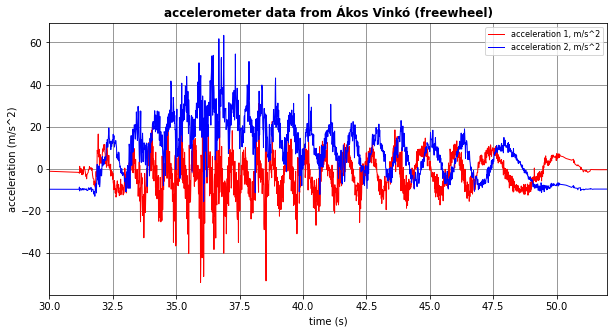

In [9]:
data = np.loadtxt("./dat/asz.dat")
t = data[:,0]
a1= data[:,1]
a2= data[:,2]

# Plot accelerometer data
plt.figure(figsize=(10,5))
plt.plot(t,a1, 'r-', label='acceleration 1, m/s^2', lw=1)
plt.plot(t,a2, 'b-', label='acceleration 2, m/s^2', lw=1)
# selected part of data:
plt.xlim(30,52)
plt.grid(color='grey')
plt.title('accelerometer data from Ákos Vinkó (freewheel)', fontweight='bold')
plt.xlabel('time (s)')
plt.ylabel('acceleration (m/s^2)')
plt.legend(loc='upper right', shadow=False, prop={'size':8}) 
plt.show()

These data are much more noisy than those by Gersdorf and Freese. Let us see how these data are processed by the extended Kalman filter.

We now have a slightly different system model since the initial phase angle of the accelerometer is not zero; moreover, sensor mounting and wheel radius are also different.

In [10]:
def EKFwheel(t,a1,a2,q=0.01,r=5):
    """
    Extended Kalman filter for dual axis acceleration sensor odometry
     t - vector of measurement epochs
     a1, a2 - measured centripetal and centrifugal accelerations (m/s**2)
     q - process noise variance (m/s**2)
     r - measurement noise variance (m/s**2)
     29.09.2019. BME Gy. Tóth
    """
    # sensor displacement from wheel axis and wheel radius
    rs = 0.165  # meter
    rw = 0.33   # meter
    nt = t.shape[0]

    # state vector: t, p,vel,acc,theta
    xe = np.zeros((nt,5))
    xe[:,0]=t
    # start
    # sensor in 'up' position at angle pi
    dist = np.pi*rw
    Qk = q**2
    Rk = r**2*np.eye(2)
    Vk = np.eye(2)
    xk = np.zeros((3))
    xk[0] = dist
    xe[0,1:4] = xk[:]
    xe[0,4] = np.pi
    Wk = np.array([0, 0, 1])
    Pk = Qk*np.outer(Wk,Wk)
    Ak = np.zeros((3,3))

    for i in range(1,nt):
        dt = t[i]-t[i-1]
        Hk = H(xk,rs,rw)
        Ak = np.eye(3)+ np.array([[0,dt,0.5*dt**2], [0,0,dt], [0,0,0]])
        zk = np.array([a1[i],a2[i]])
        # EKF step
        xk1,Pk1 = EKFstep(xk,Pk,Ak,Wk,Hk,Vk,Qk,Rk,zk,dt,rs,rw)
        xe[i,1:4] = xk1
        xk = xk1  # state update
        Pk = Pk1  # update of state covariance
        om = xk1[0]/rw  # wheel's rotation angle
        xe[i,4]=np.arctan2(np.sin(om),np.cos(om))  # angle: (-pi, pi)

    return xe

def EKFstep(xk,Pk,Ak,Wk,Hk,Vk,Qk,Rk,zk,dt,rs,rw):
    """one step of the extended Kalman filter
       29.09.2019. BME Gy. Tóth
    """
    # state update
    xkm = f(xk,dt)
    Pkm = np.dot(np.dot(Ak,Pk),Ak.T) + np.dot(np.dot(Wk,Qk),Wk.T)
    # new measurement update
    Kk = np.dot(Pkm,np.dot(Hk.T,np.linalg.pinv(np.dot(np.dot(Hk,Pkm),Hk.T) + np.dot(np.dot(Vk,Rk),Vk.T))))
    xk1 = xkm + np.dot(Kk,(zk - h(xkm,rs,rw)))
    Pk1 = Pkm - np.dot(np.dot(Kk,Hk),Pkm)

    return xk1,Pk1

Good filtering requires smaller system noise and greater measurement noise. Additionally, orientation of the $a_2$ axis must be reversed.

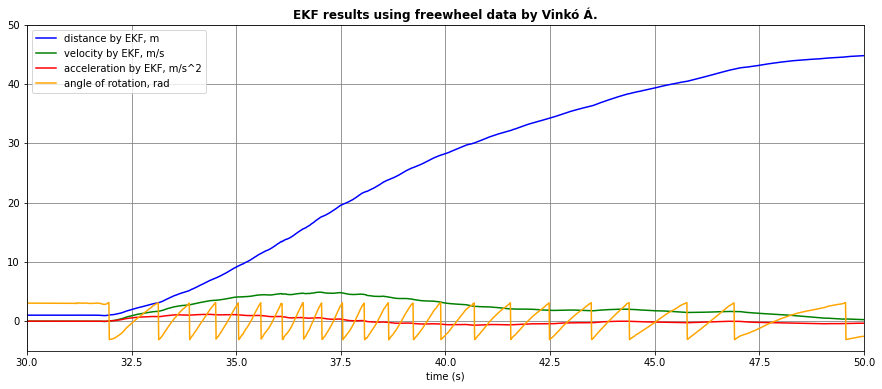

In [11]:
xe = EKFwheel(t,a1,-a2,0.01,10.0)

## plot results
plt.figure(figsize=(15,6))
plt.plot(xe[:,0],xe[:,1], 'b-', label='distance by EKF, m')
plt.plot(xe[:,0],xe[:,2], 'g-', label='velocity by EKF, m/s')
plt.plot(xe[:,0],xe[:,3], 'r-', label='acceleration by EKF, m/s^2')
plt.plot(xe[:,0],xe[:,4], color='orange', label='angle of rotation, rad')
plt.xlim(30,50)
plt.ylim(-5,50)
plt.grid(color='grey')


plt.title('EKF results using freewheel data by Vinkó Á.', fontweight='bold')
plt.xlabel('time (s)')
#plt.ylabel('distance (m), acceleration (m/s^2)')
#plt.ylabel('velocity (m/s), angle (rad)')
 
plt.legend(loc='upper left', shadow=False)
plt.show()

It is easy to recognize three parts: acceleration, breaking and run-out.